In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import warnings
from tqdm import tqdm

In [4]:
from multicam.mah import get_mah

# Collect MAH data

In [5]:
mah_data = get_mah('../../data/processed/bolshoi_m12/', cutoff_missing=0.05, cutoff_particle=0.05)

In [6]:
# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
ma = mah_data['ma']
am = mah_data['am']
ma_peak = mah_data['ma_peak']

indices = mah_data['indices']
scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


# Construct indicators and merger ratio at each snapshot

In [7]:
# scale factor coarser bins 
min_scale, max_scale = np.min(scales), np.max(scales)
scale_bins = np.linspace(min_scale, max_scale, 20)
scale_bins

array([0.18635   , 0.22919211, 0.27203421, 0.31487632, 0.35771842,
       0.40056053, 0.44340263, 0.48624474, 0.52908684, 0.57192895,
       0.61477105, 0.65761316, 0.70045526, 0.74329737, 0.78613947,
       0.82898158, 0.87182368, 0.91466579, 0.95750789, 1.00035   ])

In [8]:
# for each simulation scale, get MM 
# first we need merger ratio at every scale 
merger_ratio_inst  = np.zeros((len(cat), len(scales)))
merger_ratio_present = np.zeros((len(cat), len(scales)))
for i in range(len(cat)):
    for j, idx in enumerate(indices): 
        m2_name = f'm2_a{idx}' # TODO: Check what this corresponds to
        cpg_name = f'coprog_mvir_a{idx-1}' # want coprogenitor mass at previous timestep.
        mvir_name = f'mvir_a{idx}'
        
        # get inst ratios
        m2_ratio = cat[m2_name][i].item() / cat[mvir_name][i].item()
        merger_ratio_inst[i, j] = m2_ratio
        
        # present ratios
        m2_ratio = cat[m2_name][i] / cat['mvir'][i].item()
        merger_ratio_present[i, j] = m2_ratio
    

In [9]:
# construct indicator for each halo whether they have a MM in a given scale bine 
Mu = [0.3/1.3, 0.1 / 1.1 , 0.03 / (1 + 0.03), 0.01 / 1.01]
inst_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))
present_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))

# ignore all nanmax warning, these will return np.nan's which is expected. 
warnings.simplefilter("ignore", category=RuntimeWarning)

for kk, mu in enumerate(Mu):
    for jj in range(len(scale_bins) - 1):
        # get largest merger ratio in this scale bin
        mask = (scales >= scale_bins[jj]) & (scales < scale_bins[jj+1])
        inst_mask[kk, :, jj] = np.nanmax(merger_ratio_inst[:, mask], axis=1) > mu
        present_mask[kk, :, jj] = np.nanmax(merger_ratio_present[:, mask], axis=1) > mu

# Training

In [10]:
from multicam.models import LinearRegression

## Train standard MultiCAM

In [11]:
x = ma

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

mc = LinearRegression(165, 5)

In [12]:
mc.fit(x,y)

In [17]:
mc.predict(x)[4, 0], mc.predict(x[4, None, :])[0,0]

(8.377662658691406, 8.38835620880127)

In [14]:
# get mean cvir and mean predicted cvir for sanity check
cvir_mean = np.mean(cat['cvir'])
cvir_pred_mean = np.mean(mc.predict(x)[:,0])
np.abs(cvir_mean - cvir_pred_mean) / np.abs(cvir_mean)# very low error

0.00020922685260129072

## MultiCAM with merger ratios

In [18]:
x1 = ma

mask2 = np.isnan(merger_ratio_inst)
x2 = np.where(mask2, 0, merger_ratio_inst)

x = np.concatenate([x1, x2], axis=1)

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

mc_merger = LinearRegression(330, 5)

In [19]:
mc_merger.fit(x, y)

## MultiCAM with (coarse) merger ratios

In [20]:
# use coarser bins for merger bins like in the 'merger residuals' plots

x1 = ma

mask2 = np.isnan(merger_ratio_inst)
x2 = np.where(mask2, 0, merger_ratio_inst)

# use scale_bins instead of scales, take max over mergers in each bin.
x3 = np.zeros((x2.shape[0], scale_bins.shape[0]))
for ii, scale in enumerate(scales):
    jj = np.where(scale >= scale_bins)[0][-1]
    arr = np.vstack([x3[:, jj], x2[:, ii]])
    assert arr.shape == (2, 10000)
    x3[:, jj] = np.max(arr, axis=0)
    

In [21]:
x = np.concatenate([x1, x3], axis=1)

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

mc_merger2 = LinearRegression(185, 5)

In [22]:
mc_merger2.fit(x, y)

# Results

## Merger factions as a function of scale

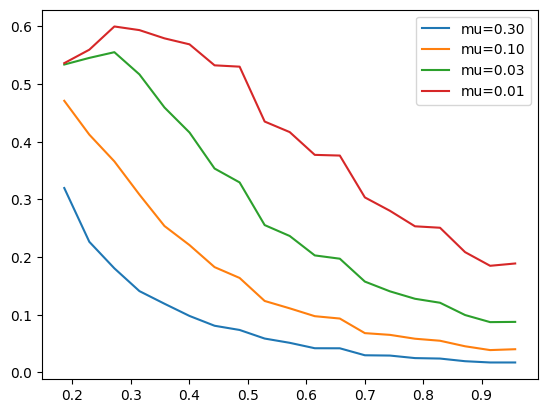

In [67]:
# instantaneous
for kk, mu in enumerate(Mu):
    _mu = mu / (1 - mu)
    plt.plot(scale_bins[:-1], inst_mask[kk, :].sum(axis=0) / 10000, label=f'mu={_mu:.2f}')
plt.legend()

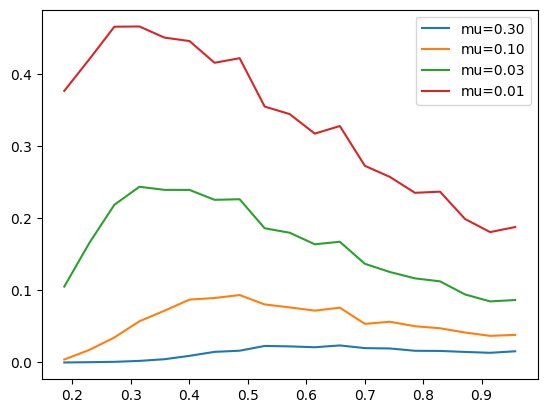

In [68]:
# present day 
for kk, mu in enumerate(Mu):
    _mu = mu / (1 - mu)
    plt.plot(scale_bins[:-1], present_mask[kk, :].sum(axis=0) / 10000, label=f'mu={_mu:.2f}')
plt.legend()

## Correlations

In [23]:
y_pred = mc.predict(x1)
y_pred_merger = mc_merger.predict(np.concatenate((x1, x2), axis=1))
y_pred_merger2 = mc_merger2.predict(np.concatenate((x1, x3), axis=1))

In [24]:
from multicam.correlations import spearmanr
params = ('cvir', 'x0', 't/|u|', 'spin_bullock', 'c_to_a')

for ii in range(5):
    print(params[ii], ":")
    print(spearmanr(y_pred[:, ii], y[:,ii]))
    print(spearmanr(y_pred_merger[:, ii], y[:,ii]))
    print(spearmanr(y_pred_merger2[:, ii], y[:,ii]))
    print()

cvir :
0.8031801980436294
0.8219745880833006
0.8278916328524659

x0 :
0.6659945795172407
0.6723452744366848
0.6760656032826146

t/|u| :
0.7538477283299423
0.7771022911064585
0.7888644748818604

spin_bullock :
0.5050793256738787
0.513115524187799
0.5031182907444088

c_to_a :
0.5367545270379389
0.5493330039673563
0.5370631538368803



The merger one is higher than the ones by the standard MultiCAM method, but are they significant?

## Get residuals per scale bin and merger ratio

### MultiCAM (standard)

In [32]:
x = ma
y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

In [67]:
y.shape

(10000, 5)

In [116]:
kk = 0
jj = 14
mask = inst_mask[kk, :, jj].astype(bool)
print(np.median(y[mask][:, 0]), np.median(y[:, 0]))
print(np.sum(mask))

4.685007572174072 9.089259624481201
247


In [115]:
scale_bins[14]

0.7861394736842106

In [118]:
np.median(mc.predict(x[mask])[:, 0])

4.98545503616333

In [ ]:
cvir_true = y[mask][:, 0]
cvir_pred

In [103]:
scale_bins

array([0.18635   , 0.22919211, 0.27203421, 0.31487632, 0.35771842,
       0.40056053, 0.44340263, 0.48624474, 0.52908684, 0.57192895,
       0.61477105, 0.65761316, 0.70045526, 0.74329737, 0.78613947,
       0.82898158, 0.87182368, 0.91466579, 0.95750789, 1.00035   ])

(0.0, 40.0)

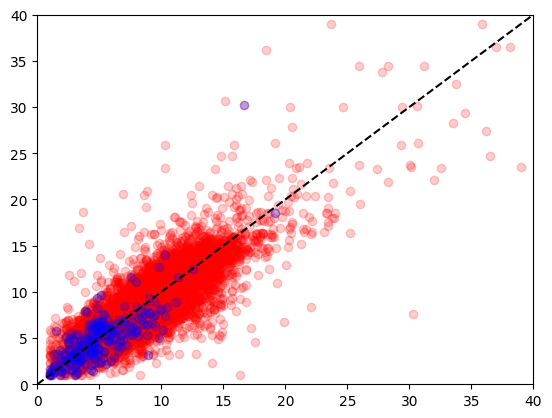

In [117]:
plt.scatter(y[:, 0], mc.predict(x)[:,0], alpha=0.2, c='r')
plt.scatter(y[:,0][mask], mc.predict(x)[:,0][mask], alpha=0.25, c='b')
plt.plot([0, 45], [0, 45], c='k', ls='--')
plt.xlim(0, 40)
plt.ylim(0,40)

In [121]:
mc.reg.coef_

Type:        ndarray
String form:
[[ 4.99703615e-02  3.47751608e-02  1.00573573e-02 -4.15216766e-02
           1.86820936e-02  8.55967629e- <...> 9199521e-02
           -7.78700221e-03  6.83816300e-02 -2.91357986e-02  3.75052977e-03
           -5.34490540e-03]]
Length:      5
File:        ~/Library/Caches/pypoetry/virtualenvs/nbody-relaxed-P7T5KfjX-py3.9/lib/python3.9/site-packages/numpy/__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an arr

In [59]:
# TODO: Try with diffmah curves instead of full MAH
scale_bins[15]

0.8289815789473685

In [43]:
scale_bins

array([0.18635   , 0.22919211, 0.27203421, 0.31487632, 0.35771842,
       0.40056053, 0.44340263, 0.48624474, 0.52908684, 0.57192895,
       0.61477105, 0.65761316, 0.70045526, 0.74329737, 0.78613947,
       0.82898158, 0.87182368, 0.91466579, 0.95750789, 1.00035   ])

In [35]:
# now get residual for each scale bin and for each mu, separating haloes using the indicators
summary_merger = np.zeros((len(Mu), len(scale_bins) - 1, len(params), 6))
summary_no_merger = np.zeros((len(Mu), len(scale_bins) - 1, len(params), 6))
resid = (mc.predict(x) - y)/y

for kk, mu in enumerate(Mu):
    for jj in tqdm(range(len(scale_bins) - 1)):
        mask = inst_mask[kk, :, jj].astype(bool)
        residuals_merger = resid[mask]
        residuals_no_merger = resid[~mask]

        summary_merger[kk, jj, :, 0] = np.median(residuals_merger, axis=0)
        summary_merger[kk, jj, :, 1] = np.percentile(residuals_merger, 25, axis=0)
        summary_merger[kk, jj, :, 2] = np.percentile(residuals_merger, 75, axis=0)
        summary_merger[kk, jj, :, 3] = np.percentile(residuals_merger, 5, axis=0)
        summary_merger[kk, jj, :, 4] = np.percentile(residuals_merger, 95, axis=0)
        summary_merger[kk, jj, :, 5] = np.mean(residuals_merger, axis=0)


        summary_no_merger[kk, jj, :, 0] = np.median(residuals_no_merger, axis=0)
        summary_no_merger[kk, jj, :, 1] = np.percentile(residuals_no_merger, 25, axis=0)
        summary_no_merger[kk, jj, :, 2] = np.percentile(residuals_no_merger, 75, axis=0)
        summary_no_merger[kk, jj, :, 3] = np.percentile(residuals_no_merger, 5, axis=0)
        summary_no_merger[kk, jj, :, 4] = np.percentile(residuals_no_merger, 95, axis=0)
        summary_no_merger[kk, jj, :, 5] = np.mean(residuals_no_merger, axis=0)


100%|██████████| 19/19 [00:00<00:00, 233.96it/s]


Text(0.5, 0, 'Scale')

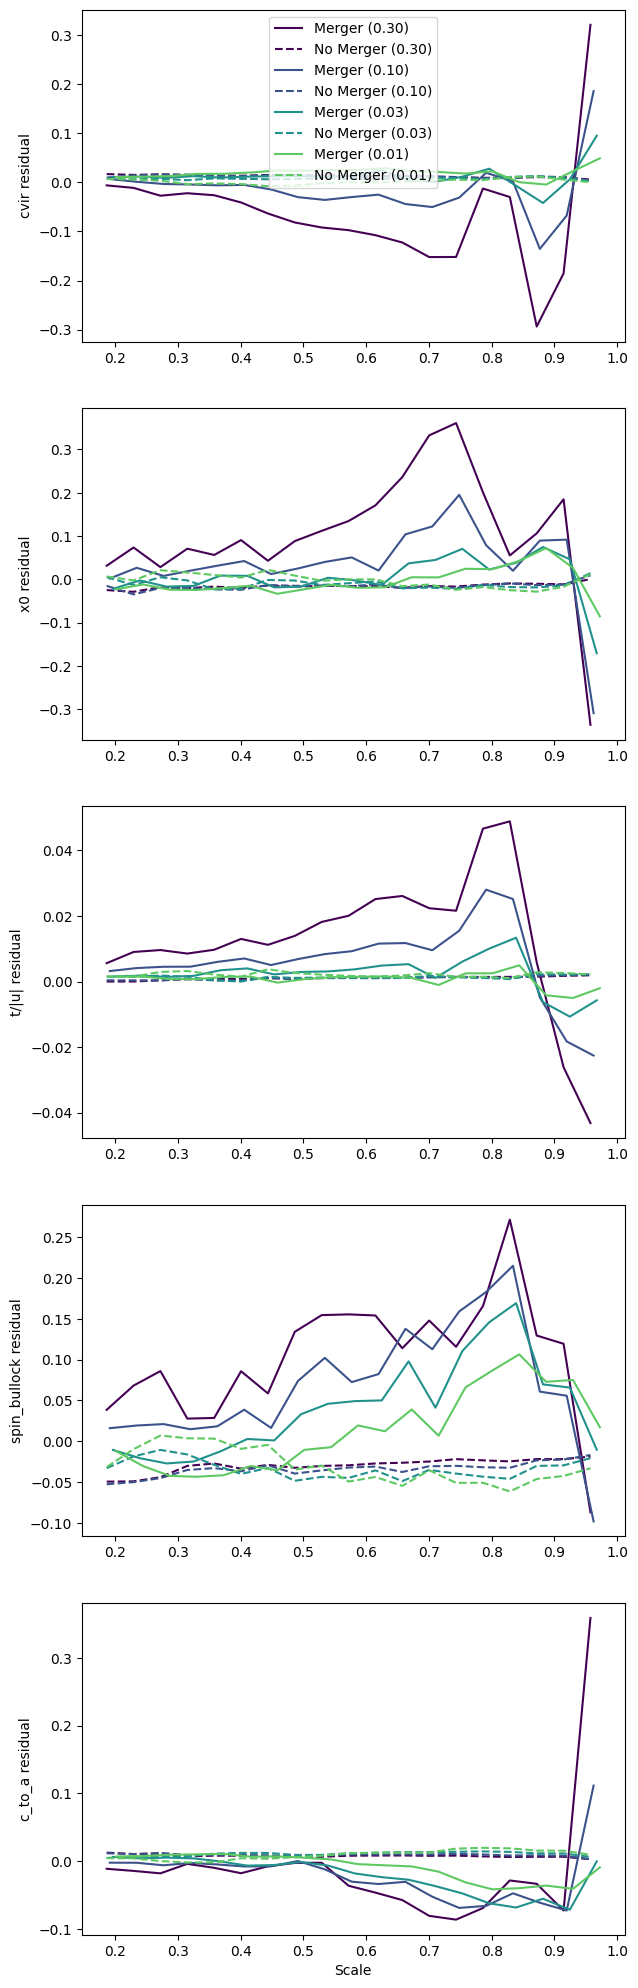

In [36]:
# make plot of median and quartile residuals for each parameter for each merger ratio as a function of scale
# all merger ratios are in the same plot with a color gradient indicating higher merger ratio
fig, axes = plt.subplots(5, 1, figsize=(7, 25))
axes = axes.flatten()
for ii, param in enumerate(params):
    for jj, mu in enumerate(Mu):
        color = plt.cm.viridis(jj / len(Mu))
        lmu = mu / ( 1- mu)
        axes[ii].plot(scale_bins[:-1]+0.005*jj, summary_merger[jj, :, ii, 0], label=f"Merger ({lmu:.2f})", color=color)
        axes[ii].plot(scale_bins[:-1], summary_no_merger[jj, :, ii, 0], label=f"No Merger ({lmu:.2f})", color=color, ls='--')
    axes[ii].set_ylabel(f'{param} residual')
axes[0].legend()
axes[-1].set_xlabel('Scale')

In [29]:
# now get residual for each scale bin and for each mu, separating haloes using the indicators
x, y = datasets['ma']['test'] # x is ma, y is (cvir, x0, t/u, spin_bullock, c_to_a)
summary_merger = np.zeros((len(Mu), len(scale_bins) - 1, len(params), 6))
summary_no_merger = np.zeros((len(Mu), len(scale_bins) - 1, len(params), 6))

for kk, mu in enumerate(Mu):
    for jj in tqdm(range(len(scale_bins) - 1)):
        mask = inst_mask[kk, :, jj].astype(bool)
        residuals_merger = (mc.predict(x[mask]) - y[mask]) / y[mask]
        residuals_no_merger = (mc.predict(x[~mask]) - y[~mask]) / y[~mask]

        summary_merger[kk, jj, :, 0] = np.median(residuals_merger, axis=0)
        summary_merger[kk, jj, :, 1] = np.percentile(residuals_merger, 25, axis=0)
        summary_merger[kk, jj, :, 2] = np.percentile(residuals_merger, 75, axis=0)
        summary_merger[kk, jj, :, 3] = np.percentile(residuals_merger, 5, axis=0)
        summary_merger[kk, jj, :, 4] = np.percentile(residuals_merger, 95, axis=0)
        summary_merger[kk, jj, :, 5] = np.mean(residuals_merger, axis=0)


        summary_no_merger[kk, jj, :, 0] = np.median(residuals_no_merger, axis=0)
        summary_no_merger[kk, jj, :, 1] = np.percentile(residuals_no_merger, 25, axis=0)
        summary_no_merger[kk, jj, :, 2] = np.percentile(residuals_no_merger, 75, axis=0)
        summary_no_merger[kk, jj, :, 3] = np.percentile(residuals_no_merger, 5, axis=0)
        summary_no_merger[kk, jj, :, 4] = np.percentile(residuals_no_merger, 95, axis=0)
        summary_no_merger[kk, jj, :, 5] = np.mean(residuals_no_merger, axis=0)


100%|██████████| 19/19 [00:25<00:00,  1.36s/it]


Text(0.5, 0, 'Scale')

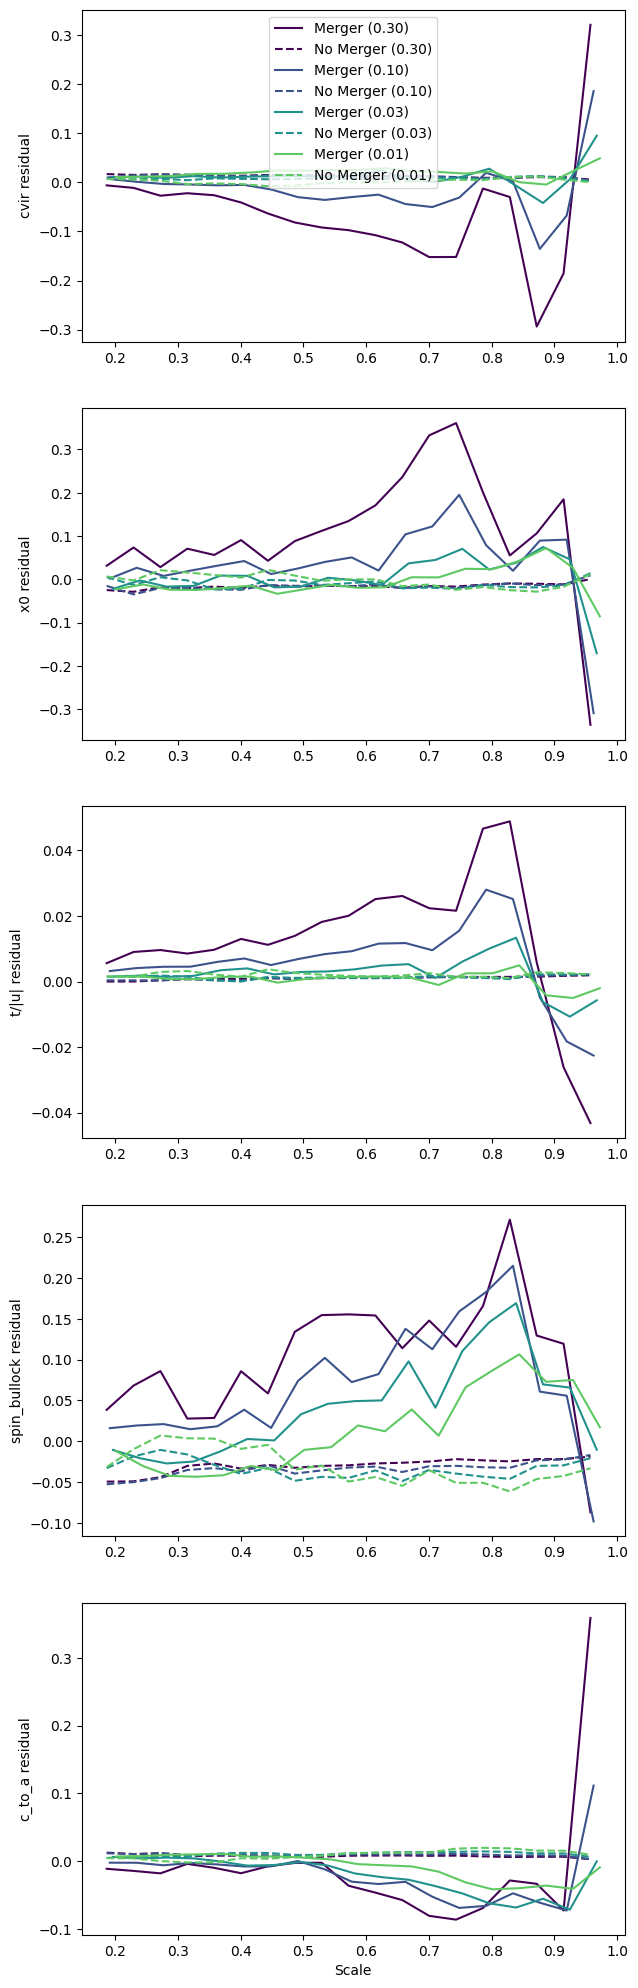

In [28]:
# make plot of median and quartile residuals for each parameter for each merger ratio as a function of scale
# all merger ratios are in the same plot with a color gradient indicating higher merger ratio
fig, axes = plt.subplots(5, 1, figsize=(7, 25))
axes = axes.flatten()
for ii, param in enumerate(params):
    for jj, mu in enumerate(Mu):
        color = plt.cm.viridis(jj / len(Mu))
        lmu = mu / ( 1- mu)
        axes[ii].plot(scale_bins[:-1]+0.005*jj, summary_merger[jj, :, ii, 0], label=f"Merger ({lmu:.2f})", color=color)
        axes[ii].plot(scale_bins[:-1], summary_no_merger[jj, :, ii, 0], label=f"No Merger ({lmu:.2f})", color=color, ls='--')
    axes[ii].set_ylabel(f'{param} residual')
axes[0].legend()
axes[-1].set_xlabel('Scale')

### MultiCAM (with merger ratios)

In [30]:
x1 = ma

mask2 = np.isnan(merger_ratio_inst)
x2 = np.where(mask2, 0, merger_ratio_inst)

x = np.concatenate([x1, x2], axis=1)

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)


In [31]:
summary_merger2 = np.zeros((len(Mu), len(scale_bins) - 1, len(params), 6))
summary_no_merger2 = np.zeros((len(Mu), len(scale_bins) - 1, len(params), 6))

for kk, mu in enumerate(Mu):
    for jj in tqdm(range(len(scale_bins) - 1)):
        mask = inst_mask[kk, :, jj].astype(bool)
        residuals_merger = (mc_merger.predict(x[mask]) - y[mask]) / y[mask]
        residuals_no_merger = (mc_merger.predict(x[~mask]) - y[~mask]) / y[~mask]

        summary_merger2[kk, jj, :, 0] = np.median(residuals_merger, axis=0)
        summary_merger2[kk, jj, :, 1] = np.percentile(residuals_merger, 25, axis=0)
        summary_merger2[kk, jj, :, 2] = np.percentile(residuals_merger, 75, axis=0)
        summary_merger2[kk, jj, :, 3] = np.percentile(residuals_merger, 10, axis=0)
        summary_merger2[kk, jj, :, 4] = np.percentile(residuals_merger, 90, axis=0)
        summary_merger2[kk, jj, :, 5] = np.mean(residuals_merger, axis=0)


        summary_no_merger2[kk, jj, :, 0] = np.median(residuals_no_merger, axis=0)
        summary_no_merger2[kk, jj, :, 1] = np.percentile(residuals_no_merger, 25, axis=0)
        summary_no_merger2[kk, jj, :, 2] = np.percentile(residuals_no_merger, 75, axis=0)
        summary_no_merger2[kk, jj, :, 3] = np.percentile(residuals_no_merger, 10, axis=0)
        summary_no_merger2[kk, jj, :, 4] = np.percentile(residuals_no_merger, 90, axis=0)
        summary_no_merger2[kk, jj, :, 5] = np.mean(residuals_no_merger, axis=0)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:30<00:00,  1.58s/it]


In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(7, 25), sharex=True)
axes = axes.flatten()
for ii, param in enumerate(params):
    for jj, mu in enumerate(Mu):
        color = plt.cm.viridis(jj / len(Mu))
        lmu = mu / ( 1- mu)
        axes[ii].plot(scale_bins[:-1]+0.005*jj, summary_merger2[jj, :, ii, 0], label=f"Merger ({lmu:.2f})", color=color)
        axes[ii].plot(scale_bins[:-1], summary_no_merger2[jj, :, ii, 0], label=f"No Merger ({lmu:.2f})", color=color, ls='--')
    axes[ii].set_ylabel(f'{param} residual')
axes[0].legend()
axes[-1].set_xlabel('Scale')

### Let's look at other summaries for spin only

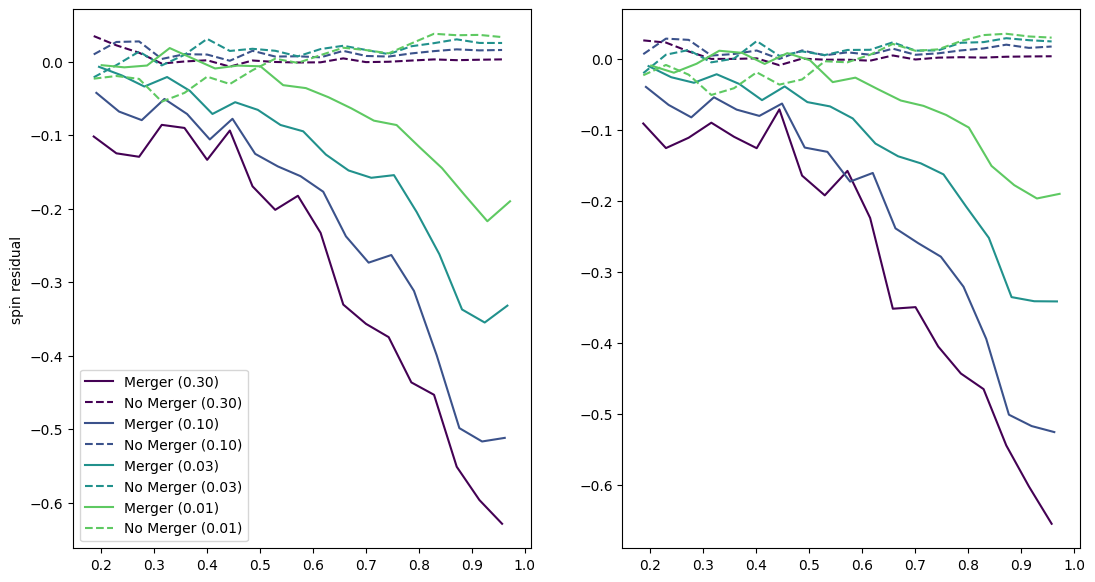

In [36]:
# median
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7), sharex=True)

for jj, mu in enumerate(Mu):
    color = plt.cm.viridis(jj / len(Mu))
    lmu = mu / ( 1- mu)
    ax1.plot(scale_bins[:-1]+0.005*jj, summary_merger[jj, :, -2, 0], label=f"Merger ({lmu:.2f})", color=color)
    ax1.plot(scale_bins[:-1], summary_no_merger[jj, :, -2, 0], label=f"No Merger ({lmu:.2f})", color=color, ls='--')

for jj, mu in enumerate(Mu):
    color = plt.cm.viridis(jj / len(Mu))
    lmu = mu / ( 1- mu)
    ax2.plot(scale_bins[:-1]+0.005*jj, summary_merger2[jj, :, -2, 0], label=f"Merger ({lmu:.2f})", color=color)
    ax2.plot(scale_bins[:-1], summary_no_merger2[jj, :, -2, 0], label=f"No Merger ({lmu:.2f})", color=color, ls='--')
ax1.set_ylabel(f'spin residual')
ax1.legend()

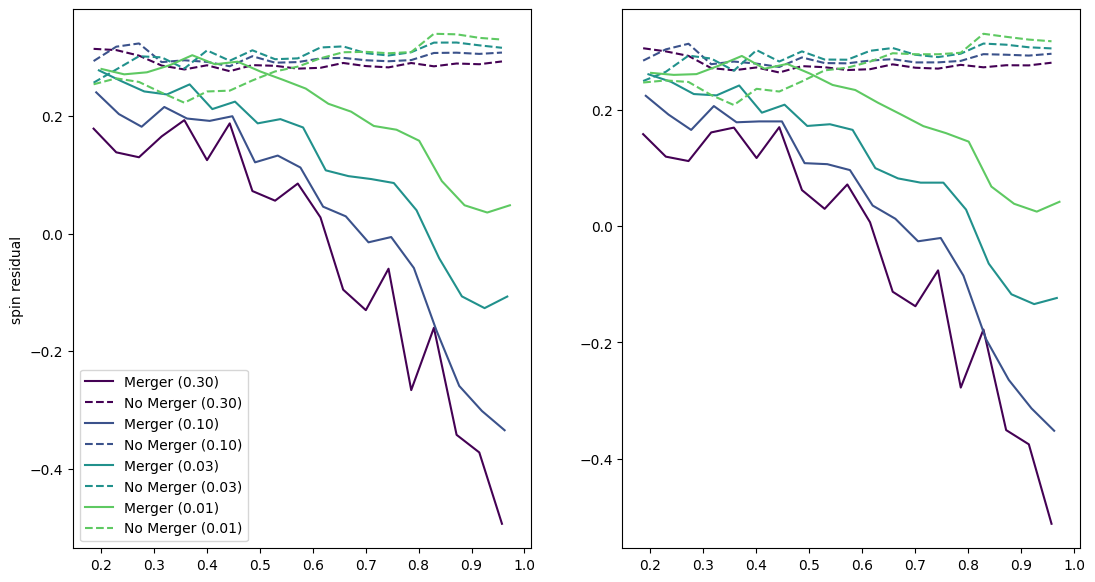

In [37]:
# mean 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7), sharex=True)

for jj, mu in enumerate(Mu):
    color = plt.cm.viridis(jj / len(Mu))
    lmu = mu / ( 1- mu)
    ax1.plot(scale_bins[:-1]+0.005*jj, summary_merger[jj, :, -2, -1], label=f"Merger ({lmu:.2f})", color=color)
    ax1.plot(scale_bins[:-1], summary_no_merger[jj, :, -2, -1], label=f"No Merger ({lmu:.2f})", color=color, ls='--')

for jj, mu in enumerate(Mu):
    color = plt.cm.viridis(jj / len(Mu))
    lmu = mu / ( 1- mu)
    ax2.plot(scale_bins[:-1]+0.005*jj, summary_merger2[jj, :, -2, -1], label=f"Merger ({lmu:.2f})", color=color)
    ax2.plot(scale_bins[:-1], summary_no_merger2[jj, :, -2, -1], label=f"No Merger ({lmu:.2f})", color=color, ls='--')
ax1.set_ylabel(f'spin residual')
ax1.legend()

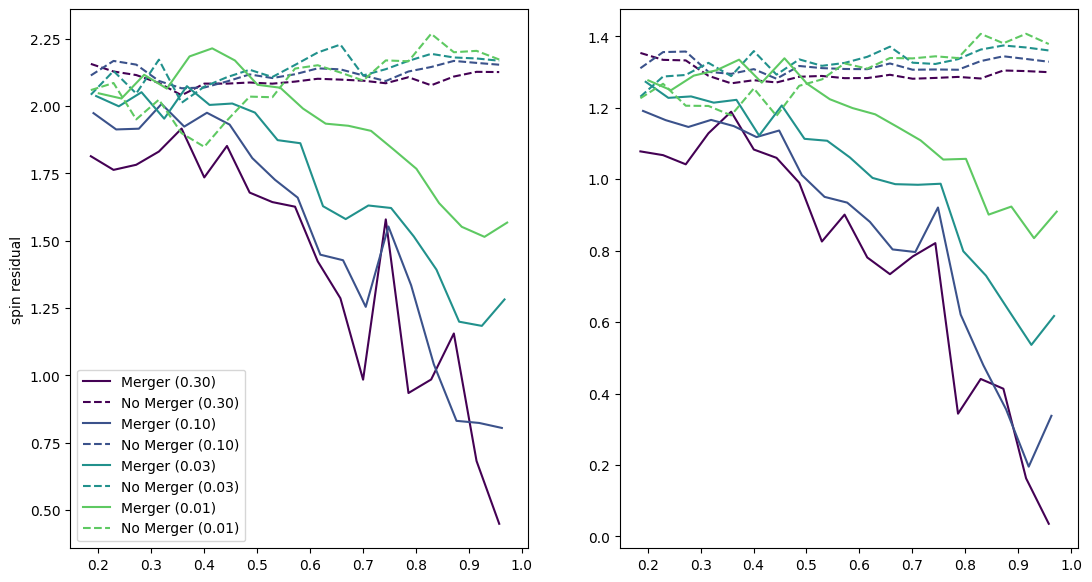

In [38]:
# 90th percentile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7), sharex=True)

for jj, mu in enumerate(Mu):
    color = plt.cm.viridis(jj / len(Mu))
    lmu = mu / ( 1- mu)
    ax1.plot(scale_bins[:-1]+0.005*jj, summary_merger[jj, :, -2, -2], label=f"Merger ({lmu:.2f})", color=color)
    ax1.plot(scale_bins[:-1], summary_no_merger[jj, :, -2, -2], label=f"No Merger ({lmu:.2f})", color=color, ls='--')

for jj, mu in enumerate(Mu):
    color = plt.cm.viridis(jj / len(Mu))
    lmu = mu / ( 1- mu)
    ax2.plot(scale_bins[:-1]+0.005*jj, summary_merger2[jj, :, -2, -2], label=f"Merger ({lmu:.2f})", color=color)
    ax2.plot(scale_bins[:-1], summary_no_merger2[jj, :, -2, -2], label=f"No Merger ({lmu:.2f})", color=color, ls='--')
ax1.set_ylabel(f'spin residual')
ax1.legend()

#### Spin residual histograms

In [44]:
x, y = datasets['ma']['test'] # x is ma, y is (cvir, x0, t/u, spin_bullock, c_to_a)
y_pred = mc.predict(x)
y_pred.shape

(10000, 5)

In [47]:
x1 = ma

mask2 = np.isnan(merger_ratio_inst)
x2 = np.where(mask2, 0, merger_ratio_inst)

x = np.concatenate([x1, x2], axis=1)

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

y_pred2 = mc_merger.predict(x)

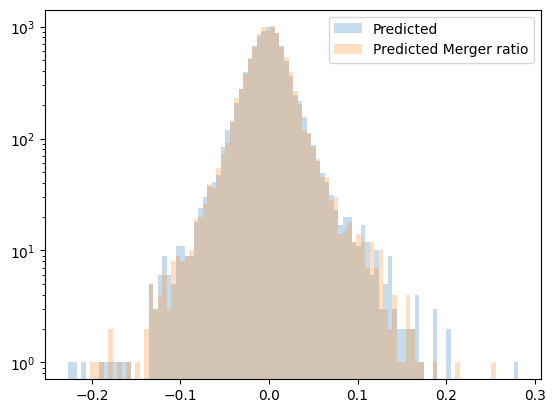

In [51]:
_, bins, _ = plt.hist(y_pred[:, -2] - y[:, -2], bins=100, alpha=0.25, label='Predicted', color='C0')
plt.hist(y_pred2[:, -2] - y[:, -2], bins=bins, alpha=0.25, label='Predicted Merger ratio', color='C1');
plt.yscale('log')
plt.legend()

#### Spin outliers MAHs

In [52]:
spin_residuals = y_pred[:, -2] - y[:, -2]
outliers = np.abs(spin_residuals) > 0.15
np.sum(outliers)

27

In [55]:
outlier_mah = ma[outliers]
outlier_mah.shape

(27, 165)

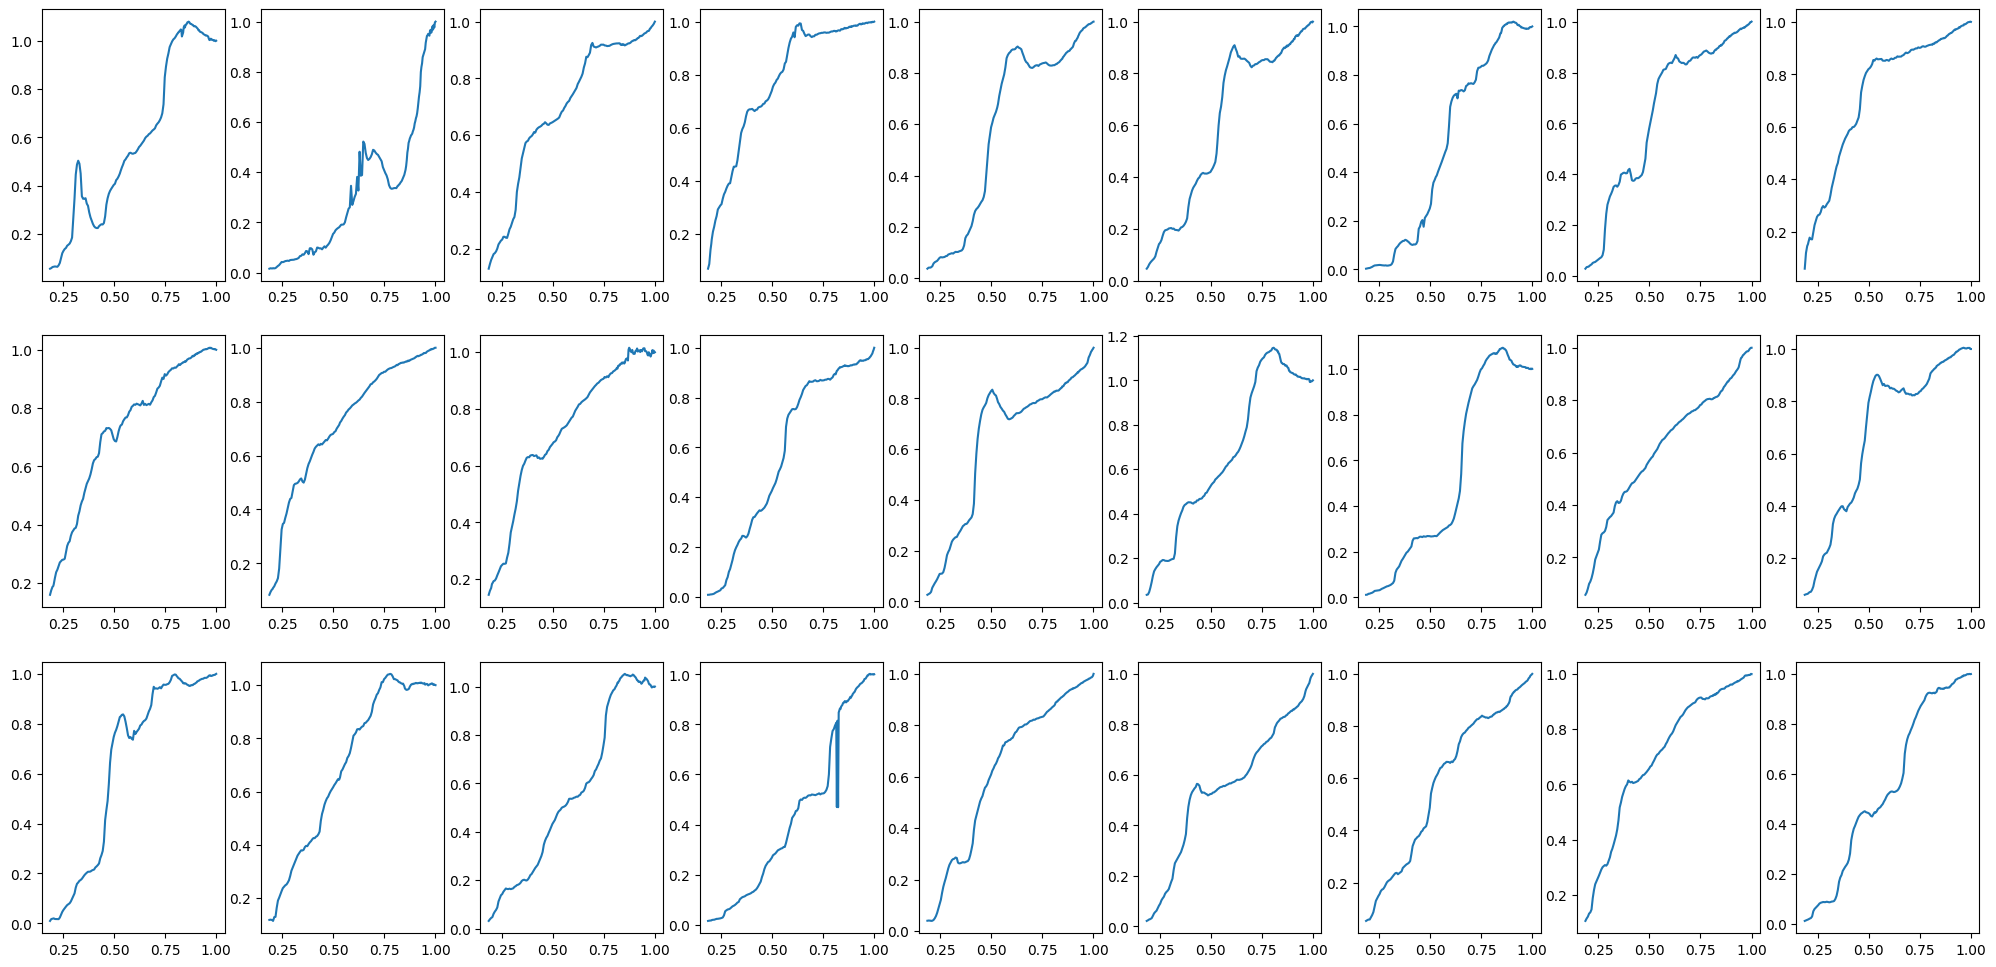

In [85]:
# plot random normal MAH
fig, axes = plt.subplots(3, 9, figsize=(25, 12))
axes = axes.flatten()
ii = np.random.randint(0, 10000, size=27)
for ii in range(27):
    axes[ii].plot(scales, ma[ii], color='C0')

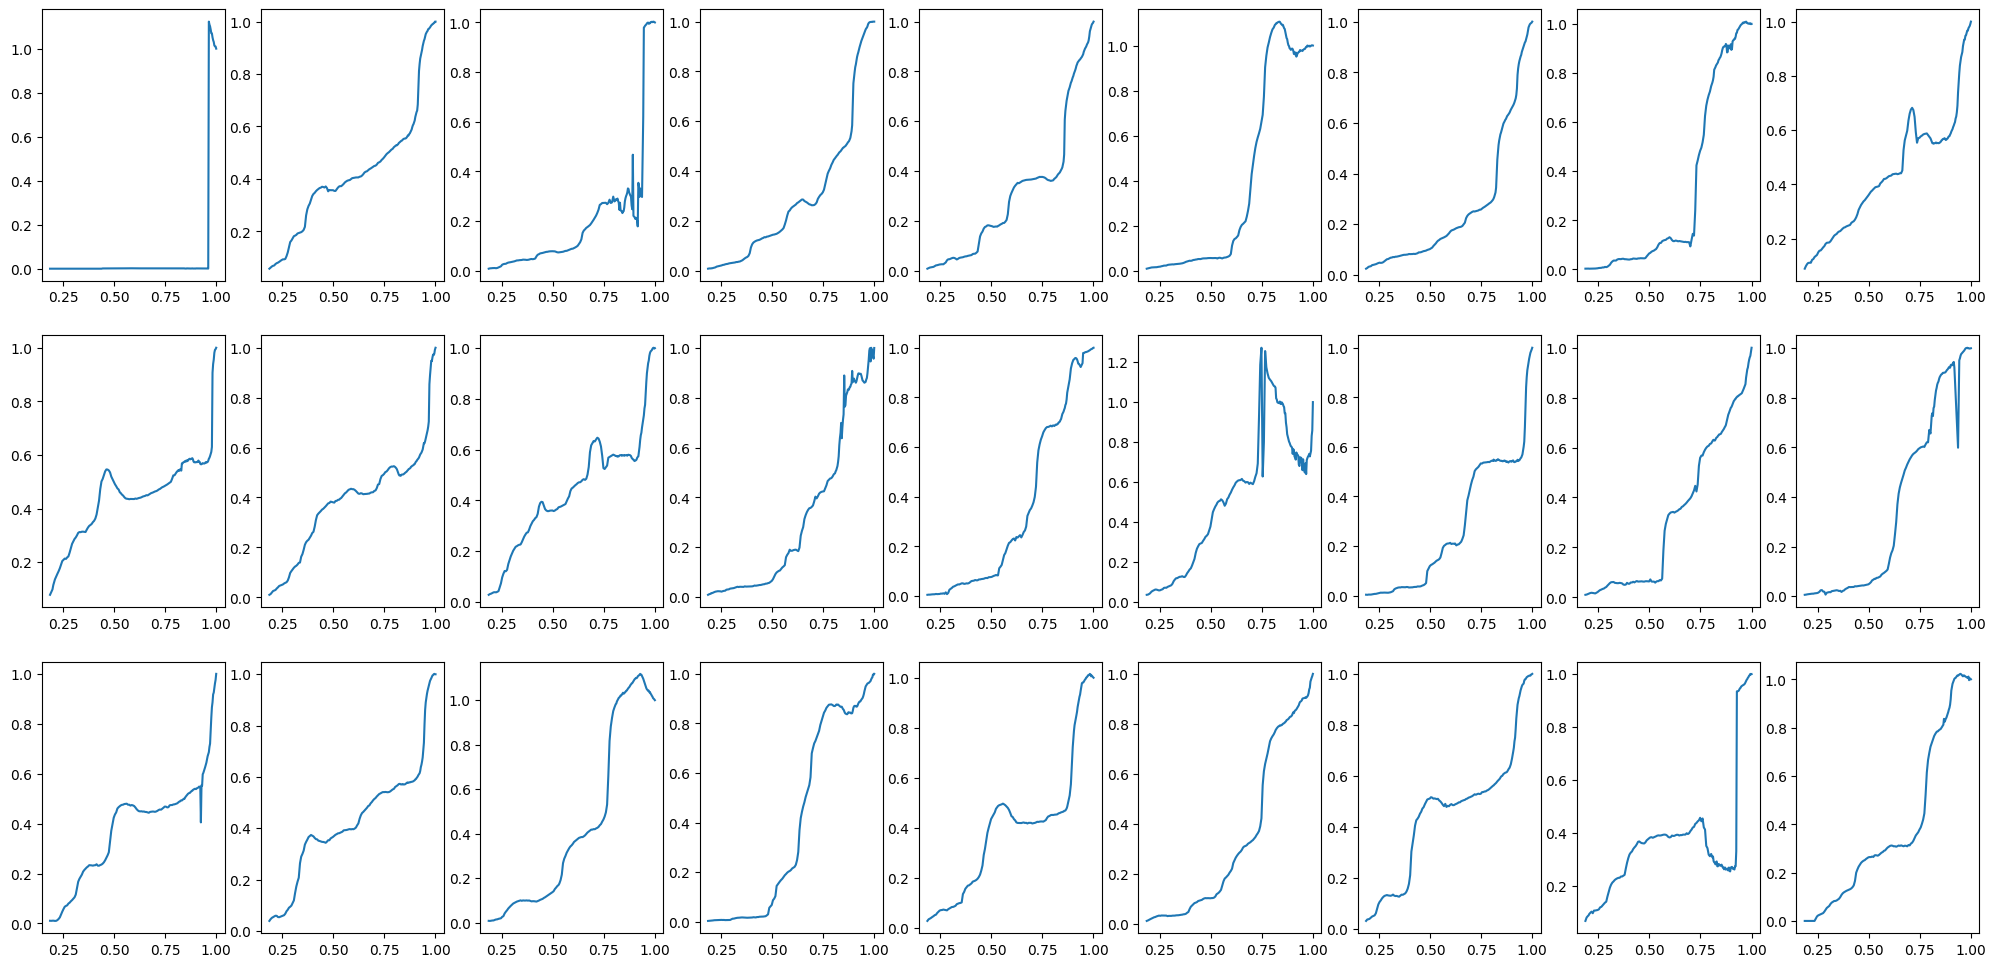

In [83]:
# plot MAH of outliers
fig, axes = plt.subplots(3, 9, figsize=(25, 12))
for ii, ax in enumerate(axes.flatten()):
    ax.plot(scales, outlier_mah[ii])

## Results on present-day quantities

### MultiCAM (standard) on present-day merger ratios

In [ ]:
# now get residual for each scale bin and for each mu, separating haloes using the indicators
x, y = datasets['ma']['test'] # x is ma, y is (cvir, x0, t/u, c_to_a, spin_bullock)
summary_merger_present = np.zeros((len(Mu), len(scale_bins) - 1, len(params), 3))
summary_no_merger_present = np.zeros((len(Mu), len(scale_bins) - 1, len(params), 3))

for kk, mu in enumerate(Mu):
    for jj in tqdm(range(len(scale_bins) - 1)):
        mask = present_mask[kk, :, jj].astype(bool)
        if mask.sum() == 0:
            residuals_merger = np.zeros((1, len(params)))
        else: 
            residuals_merger = (mc.predict(x[mask]) - y[mask]) / y[mask]
        residuals_no_merger = (mc.predict(x[~mask]) - y[~mask]) / y[~mask]

        summary_merger_present[kk, jj, :, 0] = np.median(residuals_merger, axis=0)
        summary_merger_present[kk, jj, :, 1] = np.percentile(residuals_merger, 25, axis=0)
        summary_merger_present[kk, jj, :, 2] = np.percentile(residuals_merger, 75, axis=0)

        summary_no_merger_present[kk, jj, :, 0] = np.median(residuals_no_merger, axis=0)
        summary_no_merger_present[kk, jj, :, 1] = np.percentile(residuals_no_merger, 25, axis=0)
        summary_no_merger_present[kk, jj, :, 2] = np.percentile(residuals_no_merger, 75, axis=0)

Text(0.5, 0, 'Scale')

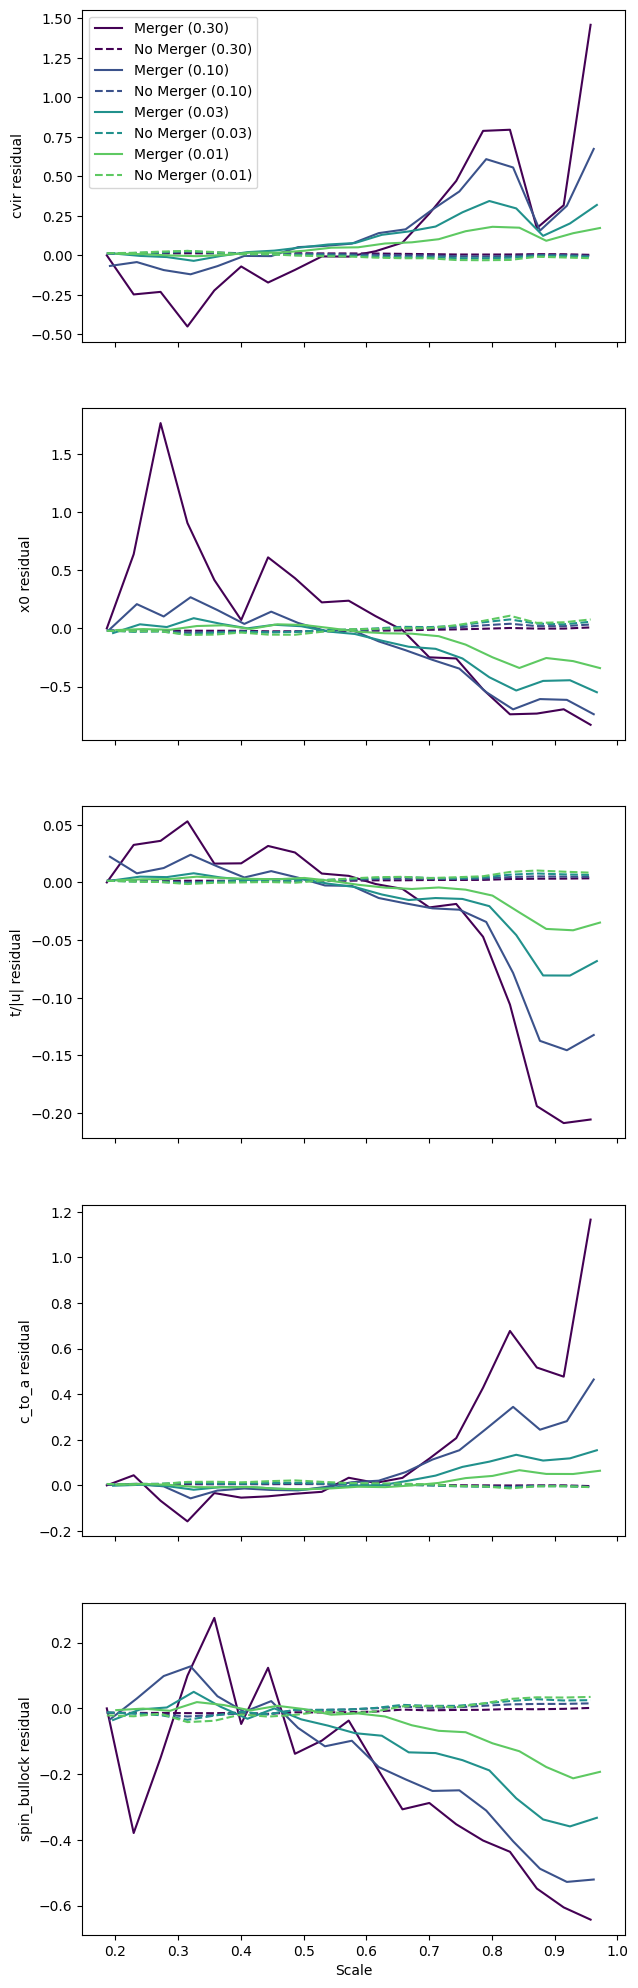

In [30]:
fig, axes = plt.subplots(5, 1, figsize=(7, 25), sharex=True)
axes = axes.flatten()
for ii, param in enumerate(params):
    for jj, mu in enumerate(Mu):
        color = plt.cm.viridis(jj / len(Mu))
        lmu = mu / ( 1- mu)
        axes[ii].plot(scale_bins[:-1]+0.005*jj, summary_merger_present[jj, :, ii, 0], label=f"Merger ({lmu:.2f})", color=color)
        axes[ii].plot(scale_bins[:-1], summary_no_merger_present[jj, :, ii, 0], label=f"No Merger ({lmu:.2f})", color=color, ls='--')
    axes[ii].set_ylabel(f'{param} residual')
axes[0].legend()
axes[-1].set_xlabel('Scale')

### Present day merger ratio MC trained and correlations

In [97]:
x1 = ma

mask2 = np.isnan(merger_ratio_present)
x2 = np.where(mask2, 0, merger_ratio_present)

x = np.concatenate([x1, x2], axis=1)

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], cat['spin_bullock'][:,None], cat['c_to_a'][:,None]], axis=1)

model_merger2 = LinearRegression(330, 5)

In [98]:
model_merger2.fit(x, y)

In [99]:
y_pred = mc.predict(x1)
y_pred_merger2 = model_merger2.predict(x)

In [101]:
from multicam.correlations import spearmanr
params = ('cvir', 'x0', 't/|u|', 'spin_bullock', 'c_to_a')

for ii in range(5):
    print(params[ii], ":")
    print(spearmanr(y_pred[:, ii], y[:,ii]))
    print(spearmanr(y_pred_merger2[:, ii], y[:,ii]))
    print()

cvir :
0.7832684537912586
0.8190424403864841

x0 :
0.6430934273390246
0.6726949595054407

t/|u| :
0.7342832835854399
0.7712686323174128

spin_bullock :
0.46021826163386026
0.5153109741730137

c_to_a :
0.520169854933361
0.5503284051180521

